In [1]:
import os
import sys
sys.path.append('..')  
import random
import pickle

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
from scipy.stats import zscore
from scipy.stats import spearmanr
from scipy.stats import ranksums

In [5]:
from statsmodels.stats.multitest import multipletests
from scipy.stats import ks_2samp, rankdata
from joblib import Parallel, delayed
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

In [6]:
from scregat.data_process import prepare_model_input, sum_counts, plot_edge, ATACGraphDataset
from run_scReGAT import *

/root/miniconda3/envs/scReGAT/lib/python3.8/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /lib/x86_64-linux-gnu/libm.so.6: version `GLIBC_2.29' not found (required by /root/miniconda3/envs/scReGAT/lib/python3.8/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/root/miniconda3/envs/scReGAT/lib/python3.8/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /lib/x86_64-linux-gnu/libm.so.6: version `GLIBC_2.29' not found (required by /root/miniconda3/envs/scReGAT/lib/python3.8/site-packages/libpyg.so)
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [7]:
# load graph

In [8]:
with open('../data/dataset_atac_core_NB.pkl', 'rb') as f:
    dataset_atac = pickle.load(f)

In [9]:
dataset_atac.list_graph[0]

Data(x=[73543, 1], edge_index=[2, 207089], y=[1], edge_tf=[80301, 2], y_exp=[7335], cell='CCTGCTACATGATCGT-1')

In [10]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [11]:
model = SCReGAT()

In [12]:
cells = dataset_atac.adata.obs_names.values

In [13]:
test_cell = random.sample(list(cells),int(len(cells) *0.5))

In [14]:
num_epoch = 4
leanring_rate = 1e-4

In [15]:
balanced_train_graph, test_graph = preprocess_graph(dataset_atac, test_cell, max_random_sample=0, seed=seed, if_test=False,is_balances=False)

Preprocess Start!



rocessing samples: 100%|██████████| 7649/7649 [00:00<00:00, 14043.22it/s]

train_graph: 3825
test_graph: 3824
random max_values: 10.903339385986328


Processing samples: 0it [00:00, ?it/s]

adding random nodes...: 0


In [16]:
model = train_model(model, balanced_train_graph, num_epoch=num_epoch, batch_size=4, lr=leanring_rate, max_grad_norm=1.0, sparse_loss_weight=0.1,
                    if_zero=False,use_device=device)


poch 1/4: 100%|██████████| 957/957 [03:42<00:00,  4.30batch/s, loss=0.207, loss1=0.0664, sparse_loss=0.141]

Epoch [1/4], Average Loss: 0.2074, Loss1: 0.0664, Sparse Loss: 0.1410



poch 2/4: 100%|██████████| 957/957 [03:20<00:00,  4.77batch/s, loss=0.14, loss1=0.000307, sparse_loss=0.14]

Epoch [2/4], Average Loss: 0.1400, Loss1: 0.0003, Sparse Loss: 0.1397



poch 3/4: 100%|██████████| 957/957 [02:28<00:00,  6.45batch/s, loss=0.139, loss1=0.000107, sparse_loss=0.139]

Epoch [3/4], Average Loss: 0.1394, Loss1: 0.0001, Sparse Loss: 0.1393


Epoch 4/4: 100%|██████████| 957/957 [03:01<00:00,  5.26batch/s, loss=0.139, loss1=4.97e-5, sparse_loss=0.139]

Epoch [4/4], Average Loss: 0.1390, Loss1: 0.0000, Sparse Loss: 0.1390


In [17]:
# add edge_tf

In [18]:
base_edge = dataset_atac.list_graph[0].edge_index
gene_edge = dataset_atac.list_graph[0].edge_tf

In [19]:
indices_not_equal = torch.nonzero(gene_edge[:, 0] != gene_edge[:, 1]).squeeze()
gene_edge = gene_edge[indices_not_equal, ].T
all_edges = torch.vstack((base_edge.T, gene_edge.T)).T
all_edges.shape 

torch.Size([2, 287379])

In [20]:
for t in dataset_atac.list_graph:
    t.edge_index = all_edges

In [21]:
dataset_atac.list_graph[0]

Data(x=[73543, 1], edge_index=[2, 287379], y=[1], edge_tf=[80301, 2], y_exp=[7335], cell='CCTGCTACATGATCGT-1')

In [22]:
res_edge, test_barcodes = test_model(dataset_atac, model, dataset_atac.list_graph, batch_size=10, device=device, if_test=False)


rocessing Batches: 100%|██████████| 765/765 [14:19<00:00,  1.12s/it]

In [23]:
# save h5ad

In [24]:
adata_edge = ad.AnnData(X=res_edge, obs=dataset_atac.adata.obs.loc[test_barcodes,])

In [25]:
adata_edge

AnnData object with n_obs × n_vars = 7649 × 287379
    obs: 'nCount_RNA', 'nFeature_RNA', 'barcode_suffix', 'X_umap1', 'X_umap2', 'balancing_weight', 'cells', 'barcode', 'sample', 'celltype', 'celltype_rna', 'nb_features'

In [24]:
edge_info = get_edge_info(dataset_atac)
edge_info['edge'] = edge_info['peak'] + "_" + edge_info['gene']

In [25]:
adata_edge.var_names = edge_info.edge.values

In [26]:
adata_edge.write_h5ad("../data/scRP_NB.h5ad")

# 2. Difference Analysis（RP、RNA、ATAC）

In [27]:
with open('../data/dataset_atac_core_NB.pkl', 'rb') as f:
    dataset_atac = pickle.load(f)

In [28]:
base_edge = dataset_atac.list_graph[0].edge_index
gene_edge = dataset_atac.list_graph[0].edge_tf
indices_not_equal = torch.nonzero(gene_edge[:, 0] != gene_edge[:, 1]).squeeze()
gene_edge = gene_edge[indices_not_equal, ].T
all_edges = torch.vstack((base_edge.T, gene_edge.T)).T
all_edges.shape 
for t in dataset_atac.list_graph:
    t.edge_index = all_edges

In [29]:
dataset_atac.list_graph[0]

Data(x=[73543, 1], edge_index=[2, 287379], y=[1], edge_tf=[80301, 2], y_exp=[7335], cell='CCTGCTACATGATCGT-1')

In [30]:
adata_edge = sc.read_h5ad("../data/scRP_NB.h5ad")
adata_edge

AnnData object with n_obs × n_vars = 7649 × 287379
    obs: 'nCount_RNA', 'nFeature_RNA', 'barcode_suffix', 'X_umap1', 'X_umap2', 'balancing_weight', 'cells', 'barcode', 'sample', 'celltype', 'celltype_rna', 'nb_features'

In [31]:
adata_edge.obs.celltype = adata_edge.obs.celltype.to_numpy()
sc.tl.rank_genes_groups(adata_edge, 'celltype', method='wilcoxon', groups=['NB_M'],reference="NB_S")
select_edges_M = sc.get.rank_genes_groups_df(adata_edge, group='NB_M')

In [32]:
select_edges_M[['peak', 'gene']] = select_edges_M['names'].str.split('_', expand=True)

In [33]:
select_edges_temp = select_edges_M[select_edges_M['peak'].str.startswith('chr')]
select_edges_temp = select_edges_temp.dropna(subset=['logfoldchanges'])

In [34]:
adata_rna = sc.read_h5ad("../data/scRNA_NB.h5ad")
adata_rna

AnnData object with n_obs × n_vars = 4925 × 33538
    obs: 'nCount_RNA', 'nFeature_RNA', 'barcode_suffix', 'X_umap1', 'X_umap2', 'balancing_weight', 'cells', 'barcode', 'sample', 'celltype'
    var: 'name'

In [35]:
# Normalizing to median total counts
sc.pp.normalize_total(adata_rna)
# Logarithmize the data
sc.pp.log1p(adata_rna)
sc.tl.rank_genes_groups(adata_rna, 'celltype', method='wilcoxon', groups=['NB_M'],reference="NB_S")
select_genes_M = sc.get.rank_genes_groups_df(adata_rna, group='NB_M')

In [36]:
adata_atac = sc.read_h5ad("../data/scATAC_NB.h5ad")
adata_atac = adata_atac[dataset_atac.adata.obs_names,select_edges_temp.peak.unique()]
adata_atac

View of AnnData object with n_obs × n_vars = 7649 × 66140
    obs: 'nCount_RNA', 'nFeature_RNA', 'barcode_suffix', 'X_umap1', 'X_umap2', 'balancing_weight', 'cells', 'barcode', 'sample', 'celltype', 'celltype_rna'
    var: 'name'

In [37]:
adata_atac.obs.celltype = adata_atac.obs.celltype.to_numpy()
sc.tl.rank_genes_groups(adata_atac, 'celltype', method='wilcoxon', groups=['NB_M'],reference="NB_S")
select_peaks_M = sc.get.rank_genes_groups_df(adata_atac, group='NB_M')

# 3. Analyzing Rank Correlations: RP vs. Expression and Accessibility

In [38]:
def calculate_gene_p_values(df, n_jobs=-1):
    """
    Perform KS-test on gene logFC values and return adjusted p-values.
    
    Args:
        df (pd.DataFrame): Input dataframe containing 'names' and 'logfoldchanges' columns.
        n_jobs (int): Number of parallel jobs to run (-1 means use all available cores).
    
    Returns:
        pd.DataFrame: Results dataframe with columns:
            - gene: Gene identifier
            - pvalue: Raw KS-test p-value
            - corrected_pvalue: FDR-adjusted p-value
            - ks_stat: KS test statistic
            Sorted by significance (corrected_pvalue)
    """
    # Standardize column names
    df.columns = ['gene', 'logfc']
    
    # Rank all logFC values (higher logFC gets better rank)
    ranks = rankdata(-df['logfc'].values)
    
    # Group ranks by gene
    gene_ranks = {}
    for gene, r in zip(df['gene'], ranks):
        gene_ranks.setdefault(gene, []).append(r)

    def ks_test(gene, granks):
        """Helper function to perform KS test for a single gene"""
        ks_stat, p = ks_2samp(granks, ranks, alternative='greater')
        return gene, p, ks_stat

    # Parallel execution of KS tests across genes
    results = Parallel(n_jobs=n_jobs)(
        delayed(ks_test)(g, gr) for g, gr in tqdm(gene_ranks.items(), desc="Performing KS tests")
    )

    # Create results dataframe
    res_df = pd.DataFrame(results, columns=['gene', 'pvalue', 'ks_stat'])
    
    # Apply FDR correction
    res_df['corrected_pvalue'] = multipletests(res_df['pvalue'], method='fdr_bh')[1]
    
    # Sort by significance and reset index
    return res_df.sort_values('corrected_pvalue').reset_index(drop=True)

### Rank

In [39]:
ris = np.mean(adata_edge[:, select_edges_temp.names].X, axis=0)
select_edges_temp['mean_ris'] = ris

In [40]:
df_peak = select_edges_temp.loc[:, ['peak', 'mean_ris']].sort_values('mean_ris',ascending=False).reset_index(drop=True)
df_ris_peak  = calculate_gene_p_values(df_peak,n_jobs=30)
df_ris_peak['peak'] = df_ris_peak['gene']


erforming KS tests: 100%|██████████| 66140/66140 [02:14<00:00, 492.34it/s]

In [41]:
df_atac = (
    pd.DataFrame({
        "peak": adata_atac.var_names,
        "mean_access": np.mean(adata_atac.X.toarray(), axis=0)
    })
    .sort_values("mean_access", ascending=False)
    .reset_index(drop=True)
)

In [42]:
df_gene = select_edges_temp.loc[:, ['gene', 'mean_ris']].sort_values('mean_ris',ascending=False).reset_index(drop=True)
df_ris_gene  = calculate_gene_p_values(df_gene,n_jobs=30)


erforming KS tests: 100%|██████████| 7334/7334 [00:13<00:00, 538.40it/s]

In [43]:
df_rna = (
    pd.DataFrame({
        "gene": adata_rna.var_names,
        "mean_exp": np.mean(adata_rna.X.toarray(), axis=0)
    })
    .sort_values("mean_exp", ascending=False)
    .reset_index(drop=True)
)

In [44]:
# Add ranking columns and merge the DataFrames
df_merged_peak = (
    df_atac.assign(rank_atac=df_atac['mean_access'].rank(ascending=False))  # Rank ATAC-seq peaks by mean accessibility (higher accessibility = better rank)
          .merge(
              df_ris_peak.assign(rank_ris=df_ris_peak['corrected_pvalue'].rank(ascending=True)),  # Rank RIS peaks by corrected p-value (more significant = better rank)
              on='peak'  # Merge on peak identifier
          )
)

# Calculate Spearman correlation between the two ranking systems
corr, p = spearmanr(df_merged_peak['rank_atac'], df_merged_peak['rank_ris'])
print(f"Spearman correlation: {corr:.3f}, p-value: {p:.3e}")

Spearman correlation: 0.229, p-value: 0.000e+00


In [45]:
# Add ranking columns and merge the DataFrames
df_merged_gene = (
    df_rna.assign(rank_rna=df_rna['mean_exp'].rank(ascending=False))  # Rank genes by mean expression (higher expression = better rank)
          .merge(
              df_ris_gene.assign(rank_ris=df_ris_gene['corrected_pvalue'].rank(ascending=True)),  # Rank RIS genes by corrected p-value (more significant = better rank)
              on='gene'  # Merge on gene identifier
          )
)

# Calculate Spearman correlation between the two ranking systems
corr, p = spearmanr(df_merged_gene['rank_rna'], df_merged_gene['rank_ris'])
print(f"Spearman correlation: {corr:.3f}, p-value: {p:.3e}")

Spearman correlation: 0.003, p-value: 7.669e-01


### Difference-Rank

In [46]:
df_logFC_peak = select_edges_temp.loc[:, ['peak', 'logfoldchanges']].sort_values('logfoldchanges',ascending=False).reset_index(drop=True)
df_ris_logFC_peak  = calculate_gene_p_values(df_logFC_peak,n_jobs=30)
df_ris_logFC_peak['peak'] = df_ris_logFC_peak['gene']


erforming KS tests: 100%|██████████| 66140/66140 [02:00<00:00, 549.79it/s]

In [47]:
df_logFC_atac = (
    select_peaks_M[['names', 'logfoldchanges']]
    .rename(columns={'names': 'peak'})
    .sort_values('logfoldchanges', ascending=False)
    .reset_index(drop=True)
)


In [48]:
df_logFC_gene = select_edges_temp.loc[:, ['gene', 'logfoldchanges']].sort_values('logfoldchanges',ascending=False).reset_index(drop=True)
df_ris_logFC_gene  = calculate_gene_p_values(df_logFC_gene,n_jobs=30)


erforming KS tests: 100%|██████████| 7334/7334 [00:13<00:00, 538.43it/s]

In [49]:
select_genes_M = select_genes_M.loc[select_genes_M.names.isin(select_edges_temp.gene.unique()),]
df_logFC_rna = (
    select_genes_M[['names', 'logfoldchanges']]
    .rename(columns={'names': 'gene'})
    .sort_values('logfoldchanges', ascending=False)
    .reset_index(drop=True)
)


In [50]:
# Add ranking columns and merge the DataFrames
df_logFC_merged_peak = (
    df_logFC_atac.assign(rank_atac=df_logFC_atac['logfoldchanges'].rank(ascending=False))  # Rank peaks by logFC values (higher logFC = better rank)
          .merge(
              df_ris_logFC_peak.assign(rank_ris=df_ris_logFC_peak['corrected_pvalue'].rank(ascending=True)),  # Rank RIS peaks by corrected p-value (more significant = better rank)
              on='peak'  # Merge on peak identifier
          )
)

# Calculate Spearman correlation between the two ranking systems
corr, p = spearmanr(df_logFC_merged_peak['rank_atac'], df_logFC_merged_peak['rank_ris'])
print(f"Spearman correlation: {corr:.3f}, p-value: {p:.3e}")

Spearman correlation: 0.146, p-value: 0.000e+00


In [51]:
# Add ranking columns and merge the DataFrames
df_logFC_merged_gene = (
    df_logFC_rna.assign(rank_rna=df_logFC_rna['logfoldchanges'].rank(ascending=False))  # Rank genes by logFC values (higher fold change = better rank)
          .merge(
              df_ris_logFC_gene.assign(rank_ris=df_ris_logFC_gene['corrected_pvalue'].rank(ascending=True)),  # Rank RIS genes by significance (more significant = better rank)
              on='gene'  # Merge on gene identifier
          )
)

# Calculate Spearman's rank correlation between differential expression and regulatory significance
corr, p = spearmanr(df_logFC_merged_gene['rank_rna'], df_logFC_merged_gene['rank_ris'])
print(f"Spearman correlation: {corr:.3f}, p-value: {p:.3e}")

Spearman correlation: -0.094, p-value: 7.363e-16


# 4. Enrichment Analysis of the Top 300 Ranked Genes

In [52]:
import gseapy as gp

# Get available gene set libraries
gene_set_libraries = gp.get_library_name()

# Filter for major pathway databases (KEGG, GO, WikiPathways, Reactome, MSigDB)
pathway_libraries = [lib for lib in gene_set_libraries 
                    if lib.startswith(('KEGG', 'GO', 'Wiki', 'Reactome', 'MSigDB'))]

print(pathway_libraries)  # Display filtered pathway databases

['GO_Biological_Process_2021', 'GO_Biological_Process_2023', 'GO_Biological_Process_2025', 'GO_Cellular_Component_2021', 'GO_Cellular_Component_2023', 'GO_Cellular_Component_2025', 'GO_Molecular_Function_2021', 'GO_Molecular_Function_2023', 'GO_Molecular_Function_2025', 'KEGG_2013', 'KEGG_2015', 'KEGG_2016', 'KEGG_2019_Human', 'KEGG_2019_Mouse', 'KEGG_2021_Human', 'MSigDB_Computational', 'MSigDB_Hallmark_2020', 'MSigDB_Oncogenic_Signatures', 'Reactome_2022', 'Reactome_Pathways_2024', 'WikiPathway_2021_Human', 'WikiPathway_2023_Human', 'WikiPathways_2013', 'WikiPathways_2015', 'WikiPathways_2016', 'WikiPathways_2019_Human', 'WikiPathways_2019_Mouse', 'WikiPathways_2024_Human', 'WikiPathways_2024_Mouse']


In [53]:
gene_set_library = 'MSigDB_Hallmark_2020'

In [54]:
top_n = 300

In [55]:
# Perform pathway enrichment analysis using Enrichr

# Get top genes from RIS analysis
top_ris_genes = df_ris_logFC_gene.head(top_n).gene.tolist()
enrichr_results_ris = gp.enrichr(
    gene_list=top_ris_genes,      # Gene list from differential regulation analysis
    gene_sets=gene_set_library,   # Pathway database to test against 
    organism='human',             # Organism (human/mouse/yeast)
    outdir=None,                  # Don't save output files
    cutoff=0.05                   # FDR significance threshold
)

# Get top genes from RNA-seq differential expression 
top_de_genes = df_logFC_rna.head(top_n).gene.tolist()
enrichr_results_rna = gp.enrichr(
    gene_list=top_de_genes,       # Gene list from differential expression
    gene_sets=gene_set_library,   # Same pathway database for comparison
    organism='human',             # Keep consistent organism  
    outdir=None,
    cutoff=0.05
)

In [56]:
enrich_ris = enrichr_results_ris.results.loc[enrichr_results_ris.results['Adjusted P-value']<0.05]
enrich_ris

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,Myc Targets V1,12/200,0.000052,0.002386,0,0,4.324468,42.668557,RANBP1;LSM7;SET;SF3B3;SSB;MCM7;POLD2;MRPS18B;T...
1,MSigDB_Hallmark_2020,PI3K/AKT/mTOR Signaling,7/105,0.001035,0.023816,0,0,4.778645,32.843040,TIAM1;ARF1;PRKAR2A;CAMK4;CLTC;AKT1;GRB2


In [57]:
enrich_rna = enrichr_results_rna.results.loc[enrichr_results_rna.results['Adjusted P-value']<0.05]
enrich_rna

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,MSigDB_Hallmark_2020,mTORC1 Signaling,15/200,3.750519e-07,0.000017,0,0,5.551920,82.147331,IGFBP5;SLC2A1;TMEM97;SLC1A5;CDC25A;RRP9;HSPD1;...
1,MSigDB_Hallmark_2020,Myc Targets V1,12/200,5.186970e-05,0.001167,0,0,4.324468,42.668557,EXOSC7;EEF1B2;FBL;SNRPD2;CLNS1A;IMPDH2;RACK1;M...
2,MSigDB_Hallmark_2020,Adipogenesis,11/200,2.277105e-04,0.002050,0,0,3.929276,32.956551,JAGN1;PFKL;PFKFB3;CMBL;SLC1A5;DHCR7;TKT;HADH;D...
3,MSigDB_Hallmark_2020,E2F Targets,11/200,2.277105e-04,0.002050,0,0,3.929276,32.956551,MRE11;MTHFD2;CHEK1;CENPM;MCM5;TP53;LYAR;PAICS;...
4,MSigDB_Hallmark_2020,Myc Targets V2,6/58,2.277590e-04,0.002050,0,0,7.711146,64.675098,EXOSC5;MCM5;TMEM97;PPRC1;RRP9;HSPD1
5,MSigDB_Hallmark_2020,Unfolded Protein Response,8/113,3.060035e-04,0.002295,0,0,5.112851,41.372747,RPS14;NOP14;EXOSC5;MTHFD2;DDX10;BANF1;YIF1A;RRP9
6,MSigDB_Hallmark_2020,Cholesterol Homeostasis,6/74,8.534870e-04,0.005134,0,0,5.891957,41.633629,LGALS3;CHKA;SCD;ETHE1;TMEM97;DHCR7
7,MSigDB_Hallmark_2020,Epithelial Mesenchymal Transition,10/200,9.126382e-04,0.005134,0,0,3.540835,24.782909,LGALS1;ID2;ELN;TIMP3;PCOLCE;SLIT3;VIM;FSTL1;FG...


# 5. Prognostic Survival Analysis of the Top 300 Ranked Genes

In [58]:
sur = pd.read_csv("../data/NB_Survival.csv",index_col=0)
sur['group'] = "Yes"
sur.loc[sur.hazard_ratio<1,"group"] = "No"

In [59]:
sur = sur.loc[(sur.p_value<0.05) & (sur.group=='Yes')]

In [60]:
top_n = 300

In [61]:
np.mean(1/df_logFC_rna.head(top_n).loc[df_logFC_rna.gene.isin(sur.gene)].index) 

0.008640897252616202

In [62]:
np.mean(1/df_ris_logFC_gene.head(top_n).loc[df_ris_logFC_gene.gene.isin(sur.gene)].index)

0.037070072661554966

In [63]:
# HLA-A

In [64]:
dateset = pd.read_csv("../data/Cohort_survival.txt",sep='\t',index_col=1)
dateset = dateset.iloc[:,1:]

In [65]:
# Data retrieval function
def get_gene_data(gene, dateset):
    """
    Retrieve gene expression, survival time, and MYCN status for a given gene.

    Parameters:
    - gene: Gene name (string)
    - dateset: DataFrame containing gene expression and clinical metadata

    Returns:
    - data: Processed DataFrame with gene expression and survival-related info
    """
    # Construct the data frame
    data = pd.DataFrame({
        "gene_expression": dateset.loc[gene].values,
        "survival_time": dateset.loc["overall_survival"].values,  # Round up if needed
        "status": dateset.loc["event_overall"].values,
        "mycn_status": dateset.loc["mycn_status"].values
    })

    # Preprocess the data
    data['mycn_status'] = data['mycn_status'].map({'yes': "mycn_amp", 'no': "mycn_nonamp"})
    data['status'] = data['status'].map({'yes': 1, 'no': 0})  # Binary encode survival status
    data['status'] = data['status'].astype("int")
    data['survival_time'] = data['survival_time'].astype("float")
    data['gene_expression'] = data['gene_expression'].astype("float")

    return data


In [66]:
gene = "HLA-A"
scan_value=70.2728

In [67]:
df_gene = get_gene_data(gene, dateset=dateset)
df_gene = df_gene.loc[df_gene.mycn_status=='mycn_amp']

In [68]:
# Prepare data
df_gene['expression_group'] = np.where(df_gene['gene_expression'] > scan_value, 
                                      'High Expression', 
                                      'Low Expression')

# Calculate group sizes for annotation
high_count = sum(df_gene['expression_group'] == 'High Expression')
low_count = sum(df_gene['expression_group'] == 'Low Expression')


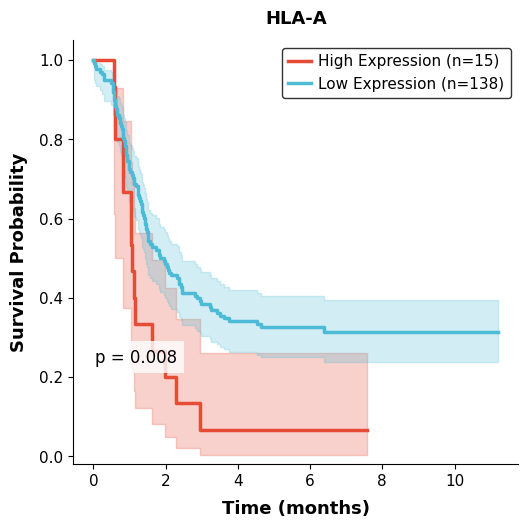

In [69]:
# Initialize the figure and axis with square aspect ratio
fig, ax = plt.subplots(figsize=(5.5, 5.5))

# Define colors for each expression group
colors = {"High Expression": "#E64B35FF", "Low Expression": "#4DBBD5FF"}

# Fit and plot Kaplan-Meier survival curves for each group
kmf = KaplanMeierFitter()
for group in colors:
    mask = df_gene['expression_group'] == group
    kmf.fit(df_gene['survival_time'][mask], df_gene['status'][mask], label=f"{group} (n={mask.sum()})")
    kmf.plot(ax=ax, ci_show=True, color=colors[group], linewidth=2.5)

# Perform log-rank test between the two groups
results = logrank_test(
    df_gene.loc[df_gene['expression_group'] == 'High Expression', 'survival_time'],
    df_gene.loc[df_gene['expression_group'] == 'Low Expression', 'survival_time'],
    df_gene.loc[df_gene['expression_group'] == 'High Expression', 'status'],
    df_gene.loc[df_gene['expression_group'] == 'Low Expression', 'status']
)

# Format p-value for display
if results.p_value < 0.0001:
    p_value_text = "p < 0.0001"
elif results.p_value < 0.001:
    p_value_text = "p < 0.001"
else:
    p_value_text = f"p = {results.p_value:.3f}"

# Add p-value annotation on the plot
ax.text(0.05, 0.25, p_value_text,
        fontsize=12, ha='left', va='center',
        bbox=dict(facecolor='white', edgecolor='none', pad=5, alpha=0.8))

# Set axis labels and title with styling
ax.set_xlabel('Time (months)', fontsize=13, fontweight='bold', labelpad=8)
ax.set_ylabel('Survival Probability', fontsize=13, fontweight='bold', labelpad=8)
ax.set_title(gene, fontsize=13, fontweight='bold', pad=12)

# Customize ticks and axis limits
ax.tick_params(axis='both', which='major', labelsize=11)
ax.set_ylim(-0.02, 1.05)
ax.grid(False)

# Customize legend appearance and position
legend = ax.legend(loc='upper right', frameon=True, fontsize=11,
                   handlelength=1.5, handletextpad=0.5)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1.0)

# Remove top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout padding
plt.tight_layout(pad=1.5)

plt.show()
